
# **COMP9414 Artificial Intelligence**
## Assignment 1: Constraint Satisfaction Search

@Authors: **Wayne Wobcke, Alfred Krzywicki, Stefano Mezza**

**Due Date:** Week 5, Friday, October 17, 5.00pm

### Objective

This assignment concerns developing optimal solutions to a scheduling problem inspired by the scenario of a manufacturing plant that has to fulfil multiple customer orders with varying deadlines, but where there may be constraints on tasks and on relationships between tasks. Any number of tasks can be scheduled at the same time, but it is possible that some tasks cannot be finished before their deadline. A task finishing late is acceptable, however incurs a cost, which for this assignment is a simple (dollar) amount per hour that the task is late.

A *fuzzy scheduling* problem in this scenario is simplified by ignoring customer orders and having just one machine and a number of *tasks*, each with a fixed duration in hours. Each task must start and finish on the same day, within working hours (9am to 5pm). In addition, there can be *constraints*, both on single tasks and between two tasks. One type of constraint is that a task can have a deadline, which can be “hard” (the deadline must be met in any valid schedule) or “soft” (the task may be finished late &ndash; though still at or before 5pm &ndash; but with a “cost” per hour for missing the deadline). The aim is to develop an overall schedule for all the tasks (in a single week) that minimizes the total cost of all the tasks that finish late, provided that all the hard constraints on tasks are satisfied.

More technically, this assignment is an example of a *constraint optimization problem* (or *constrained optimization problem*), a problem that has constraints like a standard Constraint Satisfaction Problem (CSP), but also a *cost* associated with each solution. For this assignment, we will use a *greedy* algorithm to find optimal solutions to fuzzy scheduling problems that are specified as text strings. However, unlike the greedy search algorithm described in the lectures on search, this greedy algorithm has the property that it is guaranteed to find an optimal solution for any problem (if a solution exists).

The assignment will use the AIPython code of Poole & Mackworth. You are given code to translate fuzzy scheduling problems specified as text strings into CSPs with a cost, and you are given code for several constraint solving algorithms &ndash; based on domain splitting and arc consistency, and based on depth-first search. The assignment will be to implement some missing procedures and to analyse the performance of the constraint solving methods, both analytically and experimentally.

### Submission Instructions

- This is an individual assignment.

- Write your answers in **this** notebook and submit **this** notebook on Moodle under **Assignment 1**.

- Name your submission ``<zid>-<firstname>-<lastname>.ipynb`` where ``<firstname>-<lastname>`` is your **real** (not Moodle) name.

- Make sure you set up AIPython (as done below) so the code can be run on either CSE machines or a marker's own machine.

- Do not submit any AIPython code. Hence do not change any AIPython code to make your code run.

- Make sure your notebook runs cleanly (restart the kernel, clear all outputs and run each cell to check).

- After checking that your notebook runs cleanly, run all cells and submit the notebook **with** the outputs included (do not submit the empty version).

- Make sure images (for plots/graphs) are **included** in the notebook you submit (sometimes images are saved on your machine but are not in the notebook).

- Do not modify the existing code in this notebook except to answer the questions. Marks will be given as and where indicated.

- If you want to submit additional code (e.g. for generating plots), add that at the end of the notebook.

- **Important: Do not distribute any of this code on the Internet. This includes ChatGPT. Do not put this assignment into any LLM.**

### Late Penalties

Standard UNSW late penalties apply (5% of the value of the assignment per day or part day late).

**Note:** Unlike the CSE systems, there is no grace period on Moodle. The due date and time is 5pm **precisely** on Friday October 17.

**Important: You can submit as many times as you want before the due date, but if you do submit before the due date, you cannot submit on Moodle after the due date. If you do not submit before the due date, you can submit on Moodle after the due date.**

### Plagiarism

Remember that ALL work submitted for this assignment must be your own work and no sharing or copying of code or answers is allowed. You may discuss the assignment with other students but must not collaborate on developing answers to the questions. You may use code from the Internet only with suitable attribution of the source. You may not use ChatGPT or any similar software to generate any part of your explanations, evaluations or code. Do not use public code repositories on sites such as github or file sharing sites such as Google Drive to save any part of your work &ndash; make sure your code repository or cloud storage is private and do not share any links. This also applies after you have finished the course, as we do not want next year’s students accessing your solution, and plagiarism penalties can still apply after the course has finished.

All submitted assignments will be run through plagiarism detection software to detect similarities to other submissions, including from past years. You should **carefully** read the UNSW policy on academic integrity and plagiarism (linked from the course web page), noting, in particular, that collusion (working together on an assignment, or sharing parts of assignment solutions) is a form of plagiarism.

Finally, do not use any contract cheating “academies” or online “tutoring” services. This counts as serious misconduct with heavy penalties up to automatic failure of the course with 0 marks, and expulsion from the university for repeat offenders.

### Fuzzy Scheduling

A CSP for this assignment is a set of variables representing tasks, binary constraints on pairs of tasks, and unary constraints (hard or soft) on tasks. The domains are all the working hours in one week, and a task duration is in hours. Days are represented (in the input and output) as strings ‘mon’, ‘tue’, ‘wed’, ‘thu’ and ‘fri’, and times are represented as strings ‘9am’, ‘10am’, ‘11am’, ‘12pm’, ‘1pm’, ‘2pm’, ‘3pm’, ‘4pm’ and ‘5pm’. The only possible values for the start and end times of a task are combinations of a day and times, e.g. ‘mon 9am’. Each task name is a string (with no spaces), and the only soft constraints are the soft deadline constraints.

There are three types of constraint:

- **Binary Constraints:** These specify a hard requirement for the relationship between two tasks.
- **Hard Domain Constraints:** These specify hard requirements for the tasks themselves.
- **Soft Deadline Constraints:** These constraints specify that a task may finish late, but with a given cost.

Each soft constraint has a function defining the *cost* associated with violating the preference, that the constraint solver must minimize, while respecting all the hard constraints. The *cost* of a solution is simply the sum of the costs for the soft constraints that the solution violates (and is always a non-negative integer).

This is the list of possible constraints for a fuzzy scheduling problem (comments below are for explanation and do **not** appear in the input specification; however, the code we supply *should* work with comments that take up a full line): 

```
# binary constraints
constraint, ⟨t1⟩ before ⟨t2⟩           # t1 ends when or before t2 starts
constraint, ⟨t1⟩ after ⟨t2⟩            # t1 starts after or when t2 ends
constraint, ⟨t1⟩ same-day ⟨t2⟩         # t1 and t2 are scheduled on the same day
constraint, ⟨t1⟩ starts-at ⟨t2⟩        # t1 starts exactly when t2 ends

# hard domain constraints
domain, ⟨t⟩, ⟨day⟩, hard                                    # t starts on given day at any time
domain, ⟨t⟩, ⟨time⟩, hard                                   # t starts at given time on any day
domain, ⟨t⟩, starts-before ⟨day⟩ ⟨time⟩, hard               # t starts at or before day, time
domain, ⟨t⟩, starts-after ⟨day⟩ ⟨time⟩, hard                # t starts at or after day, time
domain, ⟨t⟩, ends-before ⟨day⟩ ⟨time⟩, hard                 # t ends at or before day, time
domain, ⟨t⟩, ends-after ⟨day⟩ ⟨time⟩, hard                  # t starts at or after day, time
domain, ⟨t⟩, starts-in ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard  # day-time range for start time; includes day1, time1 and day2, time2
domain, ⟨t⟩, ends-in ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard    # day-time range for end time; includes day1, time1 and day2, time2
domain, ⟨t⟩, starts-before ⟨time⟩, hard                     # t starts at or before time on any day
domain, ⟨t⟩, ends-before ⟨time⟩, hard                       # t ends at or before time on any day
domain, ⟨t⟩, starts-after ⟨time⟩, hard                      # t starts at or after time on any day
domain, ⟨t⟩, ends-after ⟨time⟩, hard                        # t ends at or after time on any day

# soft deadline constraint
domain, ⟨t⟩, ends-by ⟨day⟩ ⟨time⟩ ⟨cost⟩, soft          # cost per hour of missing deadline
```

The input specification will consist of several “blocks”, listing the tasks, binary constraints, hard unary constraints and soft deadline constraints for the given problem. A “declaration” of each task will be included before it is used in a constraint. A sample input specification is as follows. Comments are for explanation and do **not** have to be included in the input.

```
# two tasks with two binary constraints and soft deadlines
task, t1 3
task, t2 4
# two binary constraints
constraint, t1 before t2
constraint, t1 same-day t2
# domain constraint
domain, t2 mon
# soft deadline constraints
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
```

## Preparation

### 1. Set up AIPython

You will need AIPython for this assignment. To find the aipython files, the aipython directory has to be added to the Python path.

Do this temporarily, as done here, so we can find AIPython and run your code (you will not submit any AIPython code).

You can add either the full path (using `os.path.abspath`), or as in the code below, the relative path.

In [ ]:
import sys
sys.path.append('aipython') # change to your directory
sys.path # check that aipython is now on the path

### 2. Representation of Day Times

Input and output are day time strings such as 'mon 10am' or a range of day time strings such as 'mon 10am-mon 4pm'.

The CSP will represent these as integer hour numbers in the week, ranging from 0 to 39.

The following code handles the conversion between day time strings and hour numbers.

In [ ]:
# -*- coding: utf-8 -*-
    
""" day_time string format is a day plus time, e.g. Mon 10am, Tue 4pm, or just Tue or 4pm
    if only day or time, returns day number or hour number only
    day_time strings are converted to and from integer hours in the week from 0 to 39
"""
class Day_Time():
    num_hours_in_day = 8
    num_days_in_week = 5
    
    def __init__(self):
        self.day_names = ['mon','tue','wed','thu','fri']
        self.time_names = ['9am','10am','11am','12pm','1pm','2pm','3pm','4pm']
    
    def string_to_week_hour_number(self, day_time_str):
        """ convert a single day_time into an integer hour in the week """
        value = None
        value_type = None
        day_time_list = day_time_str.split()
        if len(day_time_list) == 1:
            str1 = day_time_list[0].strip()
            if str1 in self.time_names: # this is a time
                value = self.time_names.index(str1)
                value_type = 'hour_number'
            else:
                value = self.day_names.index(str1) # this is a day
                value_type = 'day_number'
            # if not day or time, throw an exception
        else:
            value = self.day_names.index(day_time_list[0].strip())*self.num_hours_in_day \
                + self.time_names.index(day_time_list[1].strip())
            value_type = 'week_hour_number'
        return (value_type, value)

    def string_to_number_set(self, day_time_list_str):
        """ convert a list of day-times or ranges 'Mon 9am, Tue 9am-Tue 4pm' into a list of integer hours in the week
            e.g. 'mon 9am-1pm, mon 4pm' -> [0,1,2,3,4,7]
        """
        number_set = set()
        type1 = None
        for str1 in day_time_list_str.lower().split(','):
            if str1.find('-') > 0:
                # day time range
                type1, v1 = self.string_to_week_hour_number(str1.split('-')[0].strip())
                type2, v2 = self.string_to_week_hour_number(str1.split('-')[1].strip())
                if type1 != type2: return None # error, types in range spec are different
                number_set.update({n for n in range(v1, v2+1)})
            else:
                # single day time
                type2, value2 = self.string_to_week_hour_number(str1)
                if type1 != None and type1 != type2: return None # error: type in list is inconsistent
                type1 = type2
                number_set.update({value2})
        return (type1, number_set)
    
    # convert integer hour in week to day time string
    def week_hour_number_to_day_time(self, week_hour_number):
        hour = self.day_hour_number(week_hour_number)
        day = self.day_number(week_hour_number)
        return self.day_names[day]+' '+self.time_names[hour]
    
    # convert integer hour in week to integer day and integer time in day
    def hour_day_split(self, week_hour_number):
        return (self.day_hour_number(week_hour_number), self.day_number(week_hour_number))
    
    # convert integer hour in week to integer day in week
    def day_number(self, week_hour_number):
        return int(week_hour_number / self.num_hours_in_day)
    
    # convert integer hour in week to integer time in day
    def day_hour_number(self, week_hour_number):
        return week_hour_number % self.num_hours_in_day
    
    def __repr__(self):
        day_hour_number = self.week_hour_number % self.num_hours_in_day
        day_number = int(self.week_hour_number / self.num_hours_in_day)
        return self.day_names[day_number]+' '+self.time_names[day_hour_number]

### 3. Constraint Satisfaction Problems with Costs over Tasks with Durations

Since AI Python does not provide the CSP class with an explicit cost, we implement our own class that extends `CSP`.

We also store the cost functions and the durations of all tasks explicitly in the CSP.

The durations of the tasks are used in the `hold` function to evaluate constraints.

In [ ]:
from cspProblem import CSP, Constraint

# We need to override Constraint, because tasks have durations
class Task_Constraint(Constraint):
    """A Task_Constraint consists of
    * scope: a tuple of variables
    * spec: text description of the constraint used in debugging
    * condition: a function that can applied to a tuple of values for the variables
    * durations: durations of all tasks
    * func_key: index to the function used to evaluate the constraint
    """
    def __init__(self, scope, spec, condition, durations, func_key):
        super().__init__(scope, condition, spec)
        self.scope = scope
        self.condition = condition
        self.durations = durations
        self.func_key = func_key

    def holds(self, assignment):
        """returns the value of Constraint con evaluated in assignment.

        precondition: all variables are assigned in assignment
        
        CSP has only binary constraints
        condition is in the form week_hour_number1, week_hour_number2
        add task durations as appropriate to evaluate condition
        """
        if self.func_key == 'before':
            # t1 ends before t2 starts, so we need add duration to t1 assignment
            ass0 = assignment[self.scope[0]] + self.durations[self.scope[0]]
            ass1 = assignment[self.scope[1]]
        elif self.func_key == 'after':
            # t2 ends before t1 starts so we need add duration to t2 assignment
            ass0 = assignment[self.scope[0]]
            ass1 = assignment[self.scope[1]] + self.durations[self.scope[1]]
        elif self.func_key == 'starts-at':
            # t1 starts exactly when t2 ends, so we need add duration to t2 assignment
            ass0 = assignment[self.scope[0]]
            ass1 = assignment[self.scope[1]] + self.durations[self.scope[1]]
        else:
            return self.condition(*tuple(assignment[v] for v in self.scope))    
        # condition here comes from get_binary_constraint
        return self.condition(*tuple([ass0, ass1]))

# implement nodes as CSP problems with cost functions
class CSP_with_Cost(CSP):
    """ cost_functions maps a CSP var, here a task name, to a list of functions for the constraints that apply """
    def __init__(self, domains, durations, constraints, cost_functions, soft_day_time, soft_costs):
        self.domains = domains
        self.variables = self.domains.keys()
        super().__init__("title of csp", self.variables, constraints)
        self.durations = durations
        self.cost_functions = cost_functions
        self.soft_day_time = soft_day_time
        self.soft_costs = soft_costs
        self.cost = self.calculate_cost()


    # specific to fuzzy scheduling CSP problems
    def calculate_cost(self):
        """ this is really a function f = path cost + heuristic to be used by the constraint solver """
        cost = 0
        
        ####TODO: write cost function
        day_time_converter = Day_Time()

        # Check each variable v
        for v in self.variables:
            # Skip task v if it does not have a soft deadline (i.e. due at fri 5pm)
            if self.soft_day_time[v] == "fri 5pm":
                continue
            best_cost = float('inf')
            for start_time in self.domains[v]:
                # Establish parameters
                end_time = start_time + self.durations[v]
                _,deadline = day_time_converter.string_to_week_hour_number(self.soft_day_time[v])
                penalty_hours = max(0, end_time - deadline)
                # Compute cost
                penalty_cost = self.soft_costs[v] * penalty_hours
                # Update if current cost is better than best
                if penalty_cost < best_cost:
                    best_cost = penalty_cost
            # Update total cost
            cost += best_cost

        #### 
        return cost

    def __repr__(self):
        """ string representation of an arc"""
        return "CSP_with_Cost("+str(list(self.domains.keys()))+':'+str(self.cost)+")"

This formulates a solver for a CSP with cost as a search problem, using domain splitting with arc consistency to define the successors of a node.

In [ ]:
from cspConsistency import Con_solver, select, partition_domain 
from searchProblem import Arc, Search_problem
from operator import eq, le, ge

# rewrites rather than extends Search_with_AC_from_CSP
class Search_with_AC_from_Cost_CSP(Search_problem):
    """ A search problem with domain splitting and arc consistency """
    def __init__(self, csp):
        self.cons = Con_solver(csp) # copy of the CSP with access to arc consistency algorithms
        self.domains = self.cons.make_arc_consistent(csp.domains)
        self.constraints = csp.constraints
        self.cost_functions = csp.cost_functions
        self.durations = csp.durations
        self.soft_day_time = csp.soft_day_time
        self.soft_costs = csp.soft_costs
        csp.domains = self.domains # after arc consistency
        self.csp = csp

    def is_goal(self, node):
        """ node is a goal if all domains have exactly 1 element """
        return all(len(node.domains[var]) == 1 for var in node.domains)

    def start_node(self):
        return CSP_with_Cost(self.domains, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)

    def neighbors(self, node):
        """returns the neighboring nodes of node.
        """
        neighs = []
        var = select(x for x in node.domains if len(node.domains[x]) > 1) # chosen at random
        if var:
            dom1, dom2 = partition_domain(node.domains[var])
            self.display(2, "Splitting", var, "into", dom1, "and", dom2)
            to_do = self.cons.new_to_do(var, None)
            for dom in [dom1,dom2]:
                newdoms = node.domains | {var: dom} # overwrite domain of var with dom
                cons_doms = self.cons.make_arc_consistent(newdoms, to_do)
                if all(len(cons_doms[v]) > 0 for v in cons_doms):
                    # all domains are non-empty
                    # make new CSP_with_Cost node to continue the search
                    csp_node = CSP_with_Cost(cons_doms, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)
                    neighs.append(Arc(node, csp_node))
                else:
                    self.display(2,"...",var,"in",dom,"has no solution")
        return neighs    
    
    def heuristic(self, n):
        return n.cost

### 4. Fuzzy Scheduling Constraint Satisfaction Problems

The following code sets up a CSP problem from a given specification.

Hard (unary) domain constraints are applied to reduce the domains of the variables before the constraint solver runs.

In [ ]:
# domain specific CSP builder for week schedule
class CSP_builder():
    # list of text lines without comments and empty lines
    _, default_domain = Day_Time().string_to_number_set('mon 9am-fri 4pm') # should be 0,...,39
    
    # hard unary constraints: domain is a list of values, params is a single value
    # starts-before, ends-before (for starts-before duration should be 0)
    # vals in domain are actual task start/end date/time, so must be val <= whatever is in params
    def apply_before(self, param_type, params, duration, domain):
        domain_orig = domain.copy()
        param_val = params.pop()
        for val in domain_orig: # val is week_hour_number
            val1 = val + duration
            h, d = Day_Time().hour_day_split(val1)
            if param_type == 'hour_number' and h > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val1 > param_val:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_after(self, param_type, params, duration, domain):
        domain_orig = domain.copy()
        param_val = params.pop()
        for val in domain_orig: # val is week_hour_number
            val1 = val + duration
            h, d = Day_Time().hour_day_split(val1)
            if param_type == 'hour_number' and h < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val1 < param_val:
                if val in domain: domain.remove(val)
        return domain
    
    # day time range only
    # includes starts-in, ends-in
    # duration is 0 for starts-in, task duration for ends-in
    def apply_in(self, params, duration, domain):
        domain_orig = domain.copy()
        for val in domain_orig: # val is week_hour_number
            # task must be within range
            if val in domain and val+duration not in params:
                domain.remove(val)
        return domain
    
    # task must start at day/time    
    def apply_at(self, param_type, param,domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and param != h:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and param != d:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and param != val:
                if val in domain: domain.remove(val)
        return domain

    # soft deadline constraints: return cost to break constraint
    # ends-by implementation: domain_dt is the day, hour from the domain
    # constr_dt is the soft const spec, dur is the duration of task
    # soft_cost is the unit cost of completion delay
    # so if the tasks starts on domain_dt, it ends on domain_dt+dur
    """
    <t> ends-by <day> <time>, both must be specified
    delay = day_hour(T2) – day_hour(T1) + 24*(D2 - D1), 
    where day_hour(9am) = 0, day_hour(5pm) = 7
    """
    def ends_by(self, domain_dt, constr_dt_str, dur, soft_cost):
        param_type,params = Day_Time().string_to_number_set(constr_dt_str)
        param_val = params.pop()
        dom_h, dom_d = Day_Time().hour_day_split(domain_dt+dur)
        if param_type == 'week_hour_number':
            con_h, con_d = Day_Time().hour_day_split(param_val)
            return 0 if domain_dt + dur <= param_val else soft_cost*(dom_h - con_h + 24*(dom_d - con_d))
        else:
           return None # not good, must be day and time
    
    def no_cost(self, day ,hour):
        return 0
    
    # hard binary constraint, the rest are implemented as gt, lt, eq
    def same_day(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return d1 == d2
        
    # domain is a list of values
    def apply_hard_constraint(self, domain, duration, spec):
        tokens = func_key = spec.split(' ')
        if len(tokens) > 1:
           func_key = spec.split(' ')[0].strip()
           param_type, params = Day_Time().string_to_number_set(spec[len(func_key):])
           if func_key == 'starts-before':
              # duration is 0 for starts before, since we do not modify the time
              return self.apply_before(param_type, params, 0, domain)
           if func_key == 'ends-before':
               return self.apply_before(param_type, params, duration, domain)
           if func_key == 'starts-after':
              return self.apply_after(param_type,params,0,domain)
           if func_key == 'ends-after':
              return self.apply_after(param_type, params, duration, domain)
           if func_key == 'starts-in':
               return self.apply_in(params, 0, domain)
           if func_key == 'ends-in':
               return self.apply_in(params, duration, domain)
        else:
           # here we have task day or time, it has no func key so we need to parse again
           param_type,params = Day_Time().string_to_week_hour_number(spec)
           return self.apply_at(param_type, params, domain)
           
    def get_cost_function(self, spec):
        func_dict = {'ends-by':self.ends_by, 'no-cost':self.no_cost}
        return [func_dict[spec]]
    
    # spec is the text of a constraint, e.g. 't1 before t2'
    # durations are durations of all tasks
    def get_binary_constraint(self, spec, durations):
        tokens = spec.strip().split(' ')
        if len(tokens) != 3: return None # error in spec
        # task1 relation task2
        fun_dict = {'before':le, 'after':ge, 'starts-at':eq, 'same-day':self.same_day}
        return Task_Constraint((tokens[0].strip(), tokens[2].strip()), spec, fun_dict[tokens[1].strip()], durations, tokens[1].strip())
    
    def get_CSP_with_Cost(self, input_lines):
        # Note: It would be more elegant to make task a class but AIpython is not designed for this:
        # CSP_with_Cost inherits from CSP, which takes domains and constraints from all tasks instead of tasks themselves
        domains = dict()
        constraints = []
        cost_functions = dict()
        durations = dict() # durations of tasks
        soft_day_time = dict() # day time specs of soft constraints
        soft_costs = dict() # costs of soft constraints
        
        for input_line in input_lines:
            func_spec = None
            input_line_tokens = input_line.strip().split(',')
            if len(input_line_tokens) != 2: 
                return None # must have number of tokens = 2
            line_token1 = input_line_tokens[0].strip()
            line_token2 = input_line_tokens[1].strip()
            if line_token1 == 'task':
                tokens = line_token2.split(' ')
                if len(tokens) != 2: 
                    return None # must have number of tokens = 3
                key = tokens[0].strip()
                # check the duration and save it
                duration = int(tokens[1].strip())
                if duration > Day_Time().num_hours_in_day: 
                    return None
                durations[key] = duration
                # set zero cost function for this task as default, may add real cost later
                cost_functions[key] = self.get_cost_function('no-cost')
                soft_costs[key] = '0'
                soft_day_time[key] = 'fri 5pm'
                # restrict domain to times that are within allowed range
                # that is start 9-5, start+duration in 9-5
                domains[key] = {x for x in self.default_domain \
                                if Day_Time().day_number(x+duration) \
                                == Day_Time().day_number(x)}
            elif line_token1 == 'domain':
                tokens = line_token2.split(' ')
                if len(tokens) < 2: 
                    return None # must have number of tokens >= 2
                key = tokens[0].strip()
                # if soft constraint, it is handled differently from hard constraints
                if tokens[1].strip() == 'ends-by':
                    # need to retain day time and cost from the line
                    # must have task, 'end-by', day, time, cost
                    # or task, 'end-by', day, cost
                    # or task, 'end-by', time, cost
                    if len(tokens) != 5: 
                        return None 
                    # get the rest of the line after 'ends-by'
                    soft_costs[key] = int(tokens[len(tokens)-1].strip()) # last token is always cost
                    # pass the day time string to avoid passing param_type
                    day_time_str = tokens[2] + ' ' + tokens[3]
                    soft_day_time[key] = day_time_str
                    cost_functions[key] = self.get_cost_function(tokens[1].strip())
                else:
                    # the rest of domain spec, after key, are hard unary domain constraints
                    # func spec has day time, we also need duration
                    dur = durations[key]
                    func_spec = line_token2[len(key):].strip()
                    domains[key] = self.apply_hard_constraint(domains[key], dur, func_spec)       
            elif line_token1 == 'constraint': # all binary constraints
                constraints.append(self.get_binary_constraint(line_token2, durations))
            else:
                return None
            
        return CSP_with_Cost(domains, durations, constraints, cost_functions, soft_day_time, soft_costs)
    
def create_CSP_from_spec(spec: str):
    input_lines = list()    
    spec = spec.split('\n')
    # strip comments
    for input_line in spec:
        input_line = input_line.split('#')
        if len(input_line[0]) > 0:
            input_lines.append(input_line[0])
            print(input_line[0])
    # construct initial CSP problem
    csp = CSP_builder()
    csp_problem = csp.get_CSP_with_Cost(input_lines)
    return csp_problem

### 5. Greedy Search Constraint Solver using Domain Splitting and Arc Consistency

Create a GreedySearcher to search over the CSP.

The *cost* function for CSP nodes is used as the heuristic, but is actually a direct estimate of the total path cost function *f* used in A* Search.

In [ ]:
from searchGeneric import AStarSearcher

class GreedySearcher(AStarSearcher):
    """ returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    """
    def add_to_frontier(self, path):
        """ add path to the frontier with the appropriate cost """
        # value = path.cost + self.problem.heuristic(path.end()) -- A* definition
        value = path.end().cost
        self.frontier.add(path, value)      

Run the GreedySearcher on the CSP derived from the sample input.

**Note: The solution cost will always be 0 (which is wrong for the sample input) until you write the cost function in the cell above.**

In [ ]:
# Sample problem specification

sample_spec = """
# two tasks with two binary constraints and soft deadlines
task, t1 3
task, t2 4
# two binary constraints
constraint, t1 before t2
constraint, t1 same-day t2
# domain constraint
domain, t2 mon
# soft deadlines
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
"""

In [ ]:
# display details (0 turns off)
Con_solver.max_display_level = 0
Search_with_AC_from_Cost_CSP.max_display_level = 2
GreedySearcher.max_display_level = 1

def test_csp_solver(searcher):
    final_path = searcher.search()
    if final_path == None:
        print('No solution')
    else:
        domains = final_path.end().domains
        result_str = ''
        for name, domain in domains.items():
            for n in domain:
                result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(n)
        print(result_str[1:]+'\ncost: '+str(final_path.end().cost))

csp_problem = create_CSP_from_spec(sample_spec)
solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
test_csp_solver(solver)

### 6. Depth-First Search Constraint Solver

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We need to modify this code to make it compatible with the arc consistency solver.

Run the solver by calling `dfs_solve1` (first solution) or `dfs_solve_all` (all solutions).

In [ ]:
num_expanded = 0
display = False

def dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp
        context is an assignment of values to some of the variables
        var_order is a list of the variables in csp that are not in context
    """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                yield from dfs_solver(rem_cons, domains, context|{var:val}, var_order[1:])

def dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    return list(dfs_solver(csp.constraints, csp.domains, {}, var_order))

def dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    for sol in dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run the Depth-First Solver on the sample problem.

**Note: Again there are no costs calculated.**

In [ ]:
def test_dfs_solver(csp_problem):
    solution = dfs_solve1(csp_problem)
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:])

# call the Depth-First Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_dfs_solver(csp_problem) # set display to True to see nodes expanded

### 7. Depth-First Search Constraint Solver using Forward Checking with MRV Heuristic

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We redefine the `dfs_solver` methods to implement the MRV (Minimum Remaining Values) heuristic using forward checking.

Because the AIPython code is designed to manipulate domain sets, we also need to redefine `can_evaluate` to handle partial assignments.

In [ ]:
num_expanded = 0
display = False

def can_evaluate(c, assignment):
    """ assignment is a variable:value dictionary
        returns True if the constraint can be evaluated given assignment
    """
    return assignment != {} and all(v in assignment.keys() and type(assignment[v]) != list for v in c.scope)

def mrv_dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp.
        context is an assignment of values to some of the variables.
        var_order is a list of the variables in csp that are not in context.
    """
    global num_expanded, display
    if display:
        print("Context", context)
    to_eval = {c for c in constraints if can_evaluate(c, context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval] # constraints involving unset variables
            var = var_order[0]
            rem_vars = var_order[1:]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                rem_context = context|{var:val}
                # apply forward checking on remaining variables
                if len(var_order) > 1:
                    rem_vars_original = list((v, list(domains[v].copy())) for v in rem_vars)
                    if display:
                        print("Original domains:", rem_vars_original)
                    # constraints that can't already be evaluated in rem_cons
                    rem_cons_ff = [c for c in constraints if c in rem_cons and not can_evaluate(c, rem_context)]
                    for rem_var in rem_vars:
                        # constraints that can be evaluated by adding a value of rem_var to rem_context
                        any_value = list(domains[rem_var])[0]
                        rem_to_eval = {c for c in rem_cons_ff if can_evaluate(c, rem_context|{rem_var: any_value})}
                        # new domain for rem_var are the values for which all newly evaluable constraints hold
                        rem_vals = domains[rem_var].copy()
                        for rem_val in domains[rem_var]:
                            # no constraint with rem_var in the existing context can be violated
                            for c in rem_to_eval:
                                if not c.holds(rem_context|{rem_var: rem_val}):
                                    if rem_val in rem_vals:
                                        rem_vals.remove(rem_val)
                        domains[rem_var] = rem_vals
                        # order remaining variables by MRV
                        rem_vars.sort(key=lambda v: len(domains[v]))
                    if display:
                        print("After forward checking:", list((v, domains[v]) for v in rem_vars))
                if rem_vars == [] or all(len(domains[rem_var]) > 0 for rem_var in rem_vars):
                    yield from mrv_dfs_solver(rem_cons, domains, context|{var:val}, rem_vars)
                # restore original domains if changed through forward checking
                if len(var_order) > 1:
                    if display:
                        print("Restoring original domain", rem_vars_original)
                    for (v, domain) in rem_vars_original:
                        domains[v] = domain
            if display:
                print("Nodes expanded so far:", num_expanded)

def mrv_dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    return list(mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order))

def mrv_dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    for sol in mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run this solver on the sample problem.

**Note: Again there are no costs calculated.**

In [ ]:
def test_mrv_dfs_solver(csp_problem):
    solution = mrv_dfs_solve1(csp_problem)
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:])

# call the Depth-First MRV Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_mrv_dfs_solver(csp_problem) # set display to True to see nodes expanded

## Assignment

**Name:** Barry Chen

**zID:** z3374097

### Question 1 (4 marks)

Consider the search spaces for the fuzzy scheduling CSP solvers &ndash; domain splitting with arc consistency and the DFS solver (without forward checking).

- Describe the search spaces in terms of start state, successor functions and goal state(s) (1 mark)
- What is the branching factor and maximum depth to find any solution for the two algorithms (ignoring costs)? (1 mark)
- What is the worst case time and space complexity of the two search algorithms? (1 mark)
- Give one example of a fuzzy scheduling problem that is *easier* for the domain splitting with arc consistency solver than it is for the DFS solver, and explain why (1 mark)

For the second and third part-questions, give the answer in a general form in terms of fuzzy scheduling CSP size parameters.

__Answers for Question 1__

1. The *search spaces* for each of the solvers would be as follows:
    - __For domain splitting with arc consistency ('DSAC')__: a start state is a node with no assignments, a successor function that uses arc consistency to prune domains and splits the variable's domain into subdomains, and a goal state which is a node where all constraints are satisfied and all variables are assigned single values.
    - __For the DFS solver without forward checking ('DFS w/o FC')__: the start state is an empty assignment, the successor function gets the next unassigned variable and assigns it a value, and the goal state is an assignment that is complete and satisfies all constraints.

    Let $n$ = 'number of tasks', $d$ = 'average domain size per task'.

2. For the *branching factor* (i.e. the number of child nodes resulting from any given node in tree) and max depth (the longest path from root to leaf to reach complete assignment/potential solution):
    - __DSAC__: Here, we split the domain into two parts, so the branching factor = 2. We continue splitting each task's domain until each becomes solo. So this requires $log_2d$ splits per task. Therefore, for $n$ tasks, max depth = $nlog_2d$.
    - __DFS w/o FC__: Since each task has an average of $d$ choices in it domain (i.e. start times), the branching factor is $d$. The max depth for $n$ tasks is $n$, since there is one task/variable per step of path.

3. For the *worst-case time & space complexity*:
    - __DSAC__: Time = $O(2^{nlog_2d})$. Space = $O(nd)$
    - __DFS w/o FC__: Time = $O(d^n)$. Space = $O(n)$
    
4. DSAC performs better than DFS solver when early pruning is possible - the more the better. One example is one with when the domains are large, constraints are mostly unary/soft whilst binary constraints are minimal. In this situation, the DFS without forward checking would blindly check assignments which violate soft constraints before backtracking, which is relatively inefficient whereas the Domain Splitting with Arc Consistency would be able to prune large chunks of each domain given the soft deadlines so that the subdomains explored are generally those that are feasible, making these types of fuzzy scheduling problems easier for DSAC over 'DFS w/o forward checking'.



### Question 2 (5 marks)

Define the *cost* function for a fuzzy scheduling CSP (i.e. a node in the search space for domain splitting and arc consistency) as the total cost of the soft deadline constraints violated for all of the variables, assuming that each variable is assigned one of the best possible values from its domain, where a “best” value for a variable *v* is one that has the lowest cost to violate the soft deadline constraint (if any) for that variable *v*.

- Implement the cost function in the indicated cell and place a copy of the code below (3 marks)
- What is its computational complexity (give a general form in terms of fuzzy scheduling CSP size parameters)? (1 mark)
- Show that the cost function *f* never decreases along a path, and explain why this means the search algorithm is optimal (1 mark)

In [ ]:
# Code for Question 2
# specific to fuzzy scheduling CSP problems
def calculate_cost(self):
    """ this is really a function f = path cost + heuristic to be used by the constraint solver """
    cost = 0
    day_time_converter = Day_Time()

    # Check each task v
    for v in self.variables:
        # Skip task v if it does not have a soft deadline (i.e. due at fri 5pm)
        if self.soft_day_time[v] == "fri 5pm":
            continue
        
        # Reset best cost for each task
        best_cost = float('inf')

        # Check the possible start times for each task 
        for start_time in self.domains[v]:
            # Establish parameters
            end_time = start_time + self.durations[v]
            _,deadline = day_time_converter.string_to_week_hour_number(self.soft_day_time[v])
            penalty_hours = max(0, end_time - deadline)

            # Compute cost
            penalty_cost = self.soft_costs[v] * penalty_hours

            # Update if current cost is better than best
            if penalty_cost < best_cost:
                best_cost = penalty_cost

        # Update total cost
        cost += best_cost

    return cost

__Answers for Question 2__

**Computation Complexity**
- Let $n$ be the total number of tasks $v$ and let $d$ be the size average size of the domain per task (i.e. start times).
- **Time**: First, the cost function $f$ loops over each of the $n$ task so this is in $O(n)$. In each of these loops, we loop over the possible start times (i.e. the domain) so this is in $O(d)$ time. Within each of the loops, there are variables assigned and calculated (best_cost, end_time, deadline, penalty_hours, penalty_costs) and some basic conditional checks and arithmetic, all of which are constant time operations so these are all in $O(1)$ time. Therefore the total time complexity is in $O(nd)$ time.
- **Space**: Within the cost function $f$, the variable $cost$ is an int (i.e. scalar) so uses constant space. This is the case for the rest of the variables within the function (i.e. we do not use not data structures like list, dicts which would scale linearly). Therefore space complexity is in $O(1)$ time.
- **Non-decreasing**: We must show that cost function $f$ never decreases along a path. Let $f(n) = x(n) + y(n)$, where $x(n)$ is the running path cost (i.e. path cost so far) and $y(n)$ is the heuristic cost which estimates the cost of completing the remainder of the path. Consider what happens as we progress deeper down the path. More tasks are assigned, which means the running path cost increases so is $x(n)$ increasing. As more task get assigned, there are less options to choose from in terms of start times, so later tasks will have equal or worst domains than they would have if they were considered earlier. So the heuristic only gets less optimistic because there a fewer choices. Therefore $f(n)$ only gets worse (i.e. higher cost) or equal, that is, it never decreases along a path. 
- **Optimality**: For the relevant search algorithms, the frontier is ordered by cost $f(n)$ and always expands by the lowest-cost node first. This means that if a cost function is non-decreasing, then once a node is expanded, no cheaper path can ever appear later and the cheapest path to this node has been found. Therefore, since all subpaths are minimal, once we reach the goal node, since this is a path made up of optimal subpaths with minimal costs, it must be the lowest-cost solution. Therefore the search algorithm is optimal.

### Question 3 (4 marks)

Conduct an empirical evaluation of the domain splitting CSP solver using the cost function defined as above compared to using no cost function (i.e. the zero cost function, as originally defined in the above cell). Use the *average number of nodes expanded* as a metric to compare the two algorithms. 

- Write a function `generate_problem(n)` that takes an integer `n` and generates a problem specification with `n` tasks and a random set of hard constraints and soft deadline constraints in the correct format for the constraint solvers (2 marks)

Run the CSP solver (with and without the cost function) over a number of problems of size `n` for a range of values of `n`.

- Plot the performance of the two constraint solving algorithms on the above metric against `n` (1 mark)
- Quantify the performance gain (if any) achieved by the use of this cost function (1 mark)

In [ ]:
# Code for Question 3
import random

def generate_problem(n):
    """
    Takes an integer `n` and generates a problem specification with `n` tasks 
    and a random set of hard constraints and soft deadline constraints in the 
    correct format for the constraint solvers
    """
    dt = Day_Time() # To convert times for validation
    days = ['mon', 'tue', 'wed', 'thu', 'fri'] 
    times = ['9am', '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm']

    lines = []

    # Create tasks and their durations
    durations = {}
    for i in range(n+1):
        # Ignore 0 to start at task 1 
        if i == 0:
            continue
        # Since tasks must start and finish on the same day, limit duration to 8 hrs
        duration = random.randint(1,8)
        durations[i] = duration
        lines.append(f"task, t{i} {duration}")


    # Binary constraints
    binary_types = ["before", "after", "same-day", "starts-at"]
    # Generate a random number of binary constraints within a range to provide meaningful evidence
    nConstraints = random.randint(0, n//2)
    for _ in range(nConstraints):
        # Randomly pick a binary constraint and two tasks
        binaryConstraint = random.choice(binary_types)
        task1, task2 = random.sample(range(1,n+1),2)
        lines.append(f"constraint, t{task1} {binaryConstraint} t{task2}")
        

    # Hard domain constraints
    domain_types = [
        "day",
        "times", 
        "starts-before-day-time",
        "starts-after-day-time",           
        "ends-before-day-time",
        "ends-after-day-time",
        "starts-in",
        "ends-in",
        "starts-before",
        "ends-before",
        "starts-after",
        "ends-after"
        ]

    nConstraints = random.randint(0, n//3)
    for _ in range(nConstraints):
        # Randomly pick a task and hard constraint
        task = random.randint(1,n)
        duration = durations[task]
        hardConstraint = random.choice(domain_types)

        # 12 cases of hard constraints
        if hardConstraint == "day":
            lines.append(f"domain, t{task} {random.choice(days)}")
        elif hardConstraint == "times":
            lines.append(f"domain, t{task} {random.choice(times)}")
        elif hardConstraint == "starts-before-day-time":
            lines.append(f"domain, t{task} starts-before {random.choice(days)} {random.choice(times)}")
        elif hardConstraint == "starts-after-day-time":
            latest_valid_start_hour = 17 - duration
            start_hour = random.randint(9, latest_valid_start_hour)
            hour_index = dt.day_hour_number(start_hour)
            start_str = dt.time_names[hour_index]
            lines.append(f"domain, t{task} starts-after {random.choice(days)} {start_str}")
        elif hardConstraint == "ends-before-day-time":
            # Generate a valid end time that allows enough time based on duration (i.e. 3hr task should not have Mon 10am deadline)
            end_hour = random.randint(duration, 39)
            end_str = dt.week_hour_number_to_day_time(end_hour)
            lines.append(f"domain, t{task} ends-before {end_str}")
        elif hardConstraint == "ends-after-day-time":
            lines.append(f"domain, t{task} ends-after {random.choice(days)} {random.choice(times)}")
        elif hardConstraint == "starts-in":
            # Ensure start and end hour bounds are set so valid ranges based on duration
            start_hour = random.randint(0, 38-duration)
            end_hour = random.randint(start_hour+1, 39-duration)
            start_str = dt.week_hour_number_to_day_time(start_hour)
            end_str = dt.week_hour_number_to_day_time(end_hour)
            lines.append(f"domain, t{task} starts-in {start_str}-{end_str}")
        elif hardConstraint == "ends-in":
            # Ensure start and end hour bounds are set so valid ranges based on duration
            start_hour = random.randint(duration, 38)
            end_hour = random.randint(start_hour+1, 39)
            start_str = dt.week_hour_number_to_day_time(start_hour)
            end_str = dt.week_hour_number_to_day_time(end_hour)
            lines.append(f"domain, t{task} ends-in {start_str}-{end_str}")
        elif hardConstraint == "starts-before":
            lines.append(f"domain, t{task} starts-before {random.choice(times)}")
        elif hardConstraint == "starts-after":
            # Generate a valid start time that allows enough time based on duration (i.e. 3hr task should not have 10am deadline)
            latest_valid_start_hour = 17 - duration
            start_hour = random.randint(9, latest_valid_start_hour)
            hour_index = dt.day_hour_number(start_hour)
            start_str = dt.time_names[hour_index]
            lines.append(f"domain, t{task} starts-after {start_str}")
        elif hardConstraint == "ends-before":
            # Generate a valid end time that allows enough time based on duration (i.e. 3hr task should not have 10am deadline)
            earliest_valid_end_hour = 9 + duration
            end_hour = random.randint(earliest_valid_end_hour, 17)
            hour_index = dt.day_hour_number(end_hour)
            end_str = dt.time_names[hour_index]
            lines.append(f"domain, t{task} ends-before {end_str}")
        elif hardConstraint == "ends-after":
            lines.append(f"domain, t{task} ends-after {random.choice(times)}")


    # Soft deadline constraints
    # Generate a random number of soft constraints with floor to to provide optimisation pressure
    nConstraints = random.randint(n//4, n//2)
    for _ in range(nConstraints):
        # Randomly pick a task, day, time and cost for soft deadline
        task = random.randint(1,n)
        day = random.choice(days)
        time = random.choice(times)
        cost = random.randint(1,5) * 10
        lines.append(f"domain, t{task} ends-by {day} {time} {cost}")

    # Output/Return
    return "\n".join(lines)

In [ ]:
# Helper functions below to assist with analysis

import re
import matplotlib.pyplot as plt

# Modified so that results are returned as a dictionary so data can be used for analysis
def test_csp_solver_modified(searcher):
    final_path = searcher.search()
    if final_path == None:
        return {
            'solution_found': False,
            'nodes_expanded': searcher.num_expanded,
            'cost': None
        }
    else:
        return {
            'solution_found': True,
            'nodes_expanded': searcher.num_expanded,
            'cost': final_path.end().cost
        }
        # domains = final_path.end().domains
        # result_str = ''
        # for name, domain in domains.items():
        #     for n in domain:
        #         result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(n)
        # print(result_str[1:]+'\ncost: '+str(final_path.end().cost))


def make_soft_costs_zero(spec):
    """
    Matches all strings of format 't1 ends-by fri 1pm 40'
    changes the soft cost to 0, effectively simulate a zero cost function.
    """
    return re.sub(r'(ends-by\s+\w{3}\s+\d{1,2}(?:am|pm))\s+\d+', r'\1 0', spec)


def generate_and_test(nRuns, nMaxTasks):
    results_by_nTasks = {}

    # Run for increasing number of tasks
    for nTasks in range(1, nMaxTasks+1):
        # Holders for nodes expanded for each task size, for later calculations
        nodes_expanded_cost = []
        nodes_expanded_no_cost = []

        for _ in range(nRuns):
            # generate random problem
            sample_spec = generate_problem(nTasks)

            # Run DFS solver with costs
            csp_problem = create_CSP_from_spec(sample_spec)
            solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
            results = test_csp_solver_modified(solver)
            if results['solution_found']:
                nodes_expanded_cost.append(results['nodes_expanded'])

            # Run DFS solver with no costs
            no_soft_costs_sample_spec = make_soft_costs_zero(sample_spec)
            csp_problem = create_CSP_from_spec(no_soft_costs_sample_spec)
            solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
            results = test_csp_solver_modified(solver)
            if results['solution_found']:
                nodes_expanded_no_cost.append(results['nodes_expanded'])
        
        # Calculate average nodes expanded for each run of tasks
        avg_nodes_expanded_cost = round(sum(nodes_expanded_cost) / len(nodes_expanded_cost), 4)
        avg_nodes_expanded_no_cost = round(sum(nodes_expanded_no_cost) / len(nodes_expanded_no_cost), 4)

        # Calculate gain, where a positive result means cost function expanded less nodes so performance improvement
        gain = round((avg_nodes_expanded_no_cost - avg_nodes_expanded_cost), 4)

        results_by_nTasks[nTasks] = {
            'avg_nodes_with_cost':avg_nodes_expanded_cost,
            'avg_nodes_with_no_cost':avg_nodes_expanded_no_cost,
            'gain': gain
        }
    return results_by_nTasks


def plot_results_nodes_expanded(results):
    # Extract Data
    nTasks = sorted(results.keys())
    avg_nodes_expanded_cost = [results[nTask]['avg_nodes_with_cost'] for nTask in nTasks]
    avg_nodes_expanded_no_cost = [results[nTask]['avg_nodes_with_no_cost'] for nTask in nTasks]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(nTasks, avg_nodes_expanded_cost, label='With cost function', marker='o')
    plt.plot(nTasks, avg_nodes_expanded_no_cost, label='With no cost function', marker='s')
    plt.title('CSP Solver Performance with and without Cost Function')
    plt.xlabel('Number of Task (n)')
    plt.ylabel('Average Nodes Expanded')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(min(nTasks), max(nTasks)+1,1))
    plt.tight_layout()
    plt.show()

def plot_results_gain(results):
    # Extract Data
    nTasks = sorted(results.keys())
    gain = [results[nTask]['gain'] for nTask in nTasks]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(nTasks, gain, label='Node Expansions Savings with Cost Function', marker='d', color='red')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title('Performance Gain with Cost Function')
    plt.xlabel('Number of Task (n)')
    plt.ylabel('Average Nodes Saved')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(min(nTasks), max(nTasks)+1,1))
    plt.tight_layout()
    plt.show()

In [ ]:
# Generate results from 250 runs of up to 20 tasks
results = generate_and_test(250, 15)

In [ ]:
# Plot Results
plot_results_nodes_expanded(results)
plot_results_gain(results)

__Answers for Question 3__

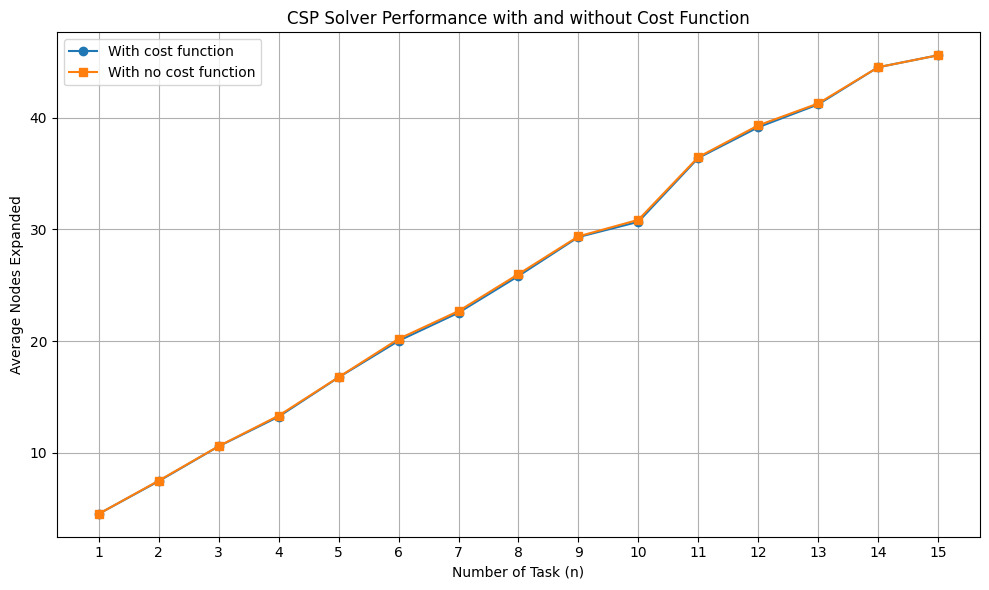
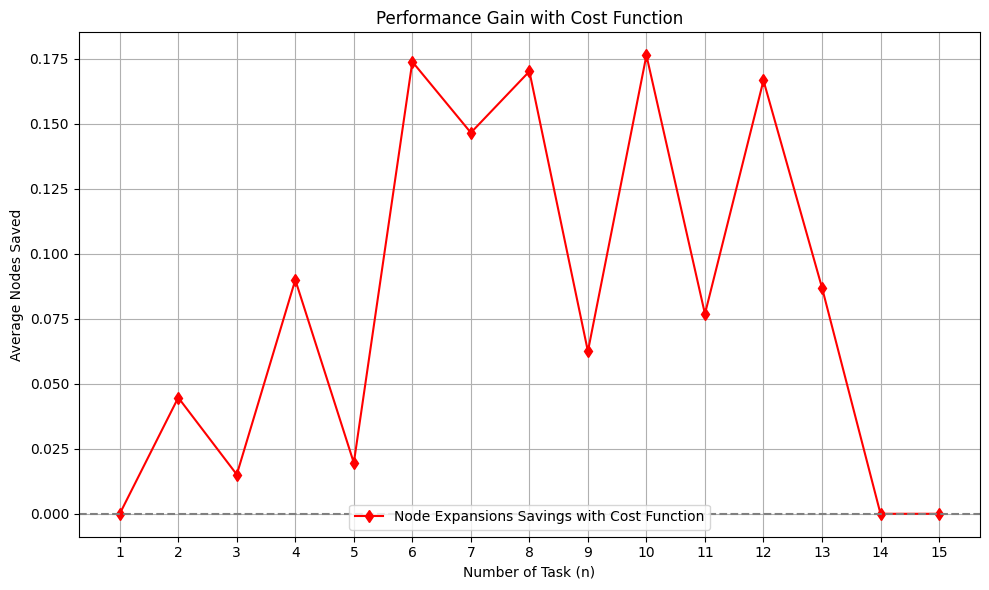


- See above for 2 plots of the results - one for 'CSP Solver Performance with and without Cost Function' and another for 'Node Expansions Savings with Cost Function'
- The results are based off a sample of 250 runs for up to 15 tasks. This number was chosen based on the reasoning that there are 40 available hours in the work week, with each task ranging from 1 to 8 hours and so expected average task time is 4 hours. Given the 40 available hours, approximately 10 tasks should fit on average. So a higher number of tasks were tested to stress test.  
- The evidence shows that there is only an insignificant quantifiable performance gain with using the cost function, with 0 to 0.175 less nodes expanded on average, mainly through the middle range of tasks between 3-13. However, this is relatively minor compared to the number nodes expanded which is 10-40+ in this same rnage of task. So the conclusion is there may possibly be a minor although insignificant performance gain with the use of a cost function.

### Question 4 (5 marks)

Compare the Depth-First Search (DFS) solver to the Depth-First Search solver using forward checking with Minimum Remaining Values heuristic (DFS-MRV). For this question, ignore the costs associated with the CSP problems. 

- What is the worst case time and space complexity of each algorithm (give a general form in terms of fuzzy scheduling problem sizes)? (1 mark)
- What are the properties of the search algorithms (completeness, optimality)? (1 mark)
- Give an example of a problem that is *easier* for the DFS-MRV solver than it is for the DFS solver, and explain why (1 mark)
- Empirically compare the quality of the first solution found by DFS and DFS-MRV compared to the optimal solution (1 mark)
- Empirically compare DFS-MRV with DFS in terms of the number of nodes expanded (1 mark)

For the empirical evaluations, run the two algorithms on a variety of problems of size `n` for varying `n`. Note that the domain splitting CSP solver with costs should always find an optimal solution.

In [ ]:
# Code for Question 4
import matplotlib.pyplot as plt
## The 2 solvers modified similar to q3 so that data can be extracted.
def test_dfs_solver_modified(csp_problem):
    solution = dfs_solve1(csp_problem)
    if solution == None:
        return {
            'solution_found': False,
            'nodes_expanded': num_expanded,
        }
    else:
        return {
            'solution_found': True,
            'nodes_expanded': num_expanded,
        }


def test_mrv_dfs_solver_modified(csp_problem):
    solution = mrv_dfs_solve1(csp_problem)
    if solution == None:
        return {
            'solution_found': False,
            'nodes_expanded': num_expanded,
        }
    else:
        return {
            'solution_found': True,
            'nodes_expanded': num_expanded,
        }


def generate_and_test_q4(nRuns, nMaxTasks):
    results_by_nTasks = {}

    # Run for increasing number of tasks
    for nTasks in range(1, nMaxTasks+1):
        # Holders for nodes expanded for each task size, for later calculations
        nodes_expanded_basic = []
        nodes_expanded_mrv = []
        # timeouts_basic = 0
        # timeouts_mrv = 0

        for _ in range(nRuns):
            # generate random problem
            sample_spec = generate_problem(nTasks)
            csp_problem = create_CSP_from_spec(sample_spec)
            # csp_problem.domains = {k: list(v) for k, v in csp_problem.domains.items()}

            # Run Basic DFS Solver 
            # results = timeout_wrapper.run_with_timeout(test_dfs_solver_modified, args=(csp_problem,), timeout=10) # set display to True to see nodes expanded
            results = test_dfs_solver_modified(csp_problem)
            if results['solution_found']:
                nodes_expanded_basic.append(results['nodes_expanded'])
            # elif results['timed_out']:
            #     timeouts_basic += 1

            # Run DFS-MRV Solver
            # results = timeout_wrapper.run_with_timeout(test_mrv_dfs_solver_modified, args=(csp_problem,), timeout=10) # set display to True to see nodes expanded
            results = test_mrv_dfs_solver_modified(csp_problem)
            if results['solution_found']:
                nodes_expanded_mrv.append(results['nodes_expanded'])
            # elif results['timed_out']:
            #     timeouts_mrv += 1

        # Calculate average nodes expanded for each run of tasks
        avg_nodes_expanded_basic = round(sum(nodes_expanded_basic) / len(nodes_expanded_basic), 4) if nodes_expanded_basic else 0
        avg_nodes_expanded_mrv = round(sum(nodes_expanded_mrv) / len(nodes_expanded_mrv), 4) if nodes_expanded_mrv else 0

        # Calculate gain, where a positive result means heuristics function expanded less nodes so performance improvement
        gain = round((avg_nodes_expanded_basic - avg_nodes_expanded_mrv), 4)

        results_by_nTasks[nTasks] = {
            'avg_nodes_basic':avg_nodes_expanded_basic,
            'avg_nodes_mrv':avg_nodes_expanded_mrv,
            'gain': gain
        }
    return results_by_nTasks


In [ ]:
# Generate results from 10 runs of up to 8 tasks
results_q4 = generate_and_test_q4(10, 8)

# print(results_q4)
# {1: {'avg_nodes_basic': 1.0, 'avg_nodes_mrv': 1.0, 'gain': 0.0}, 
#  2: {'avg_nodes_basic': 14.7143, 'avg_nodes_mrv': 2.4286, 'gain': 12.2857}, 
#  3: {'avg_nodes_basic': 3.0, 'avg_nodes_mrv': 3.0, 'gain': 0.0}, 
#  4: {'avg_nodes_basic': 11.0, 'avg_nodes_mrv': 4.25, 'gain': 6.75}, 
#  5: {'avg_nodes_basic': 5.0, 'avg_nodes_mrv': 5.0, 'gain': 0.0}, 
#  6: {'avg_nodes_basic': 17800.0, 'avg_nodes_mrv': 7.3333, 'gain': 17792.6667}, 
#  7: {'avg_nodes_basic': 0, 'avg_nodes_mrv': 0, 'gain': 0.0}, 
#  8: {'avg_nodes_basic': 8.0, 'avg_nodes_mrv': 8.0, 'gain': 0.0}}



__Answers for Question 4__

- _Complexity_: Let $n$ be the number of variables (i.e. tasks), $d$ be the domain size per variable (i.e. possible start times), $m$ be the number of constaints. For the DFS solver, it is a space efficient implementation that explores values one at a time (and does not cache or memoize) so the memory footprint is reduced. Therefore the worst case space complexity is $O(n + m)$ and time complexity is $O(d^n)$. For the DFS-MRV solver, the forward checking prunes domains whilst the MRV prioritises variables with the smallest domain. It worst case space complexity $O(d \cdot n + m)$, which is worst than the basic DFS solver because this one requires extra space to carry out the heuristics (i.e for forward checking and constraint filtering). The worst case time complexity is $O(d^n)$, the same as the basic solver. But, the expectation is that in the average case this performs better since it prunes earlier and expands fewer nodes.
- _Properties_: In general, both the basic DFS and the DFS-MRV solvers are not complete as they may get stuck following a deep or infinite path, even when a solution exists at a relatively shallow level. Both return the first solution that satisfies all constraints, which might not necessarily be the best one so both are not optimal either. 
- _Example_: Since DFS-MRV targets the most constrained variables first and forward checks to reduce domains sizes early, problems which have some tasks that have very few valid start time (i.e. highly constraints) alongside other task which very flexible and large domains (i.e. minimally constrained) are easier for this solver because the algorithm assigns the highly constrained variables first, pruning branches which are not feasible early, and then forward checks to remove invalid domain values from the remaining task, further reducing the search space. Whereas the basic DFS solver does not have these pruning mechanics and so may allocate the minimally constrained variables first and then spend time exploring unproductive routes which the other solver would not have done.

- _Empirical Analysis_: From the results in the above cell, we can see that:
    - The heuristic guided DFS has either the same or better performance than the basic DFS. In the case where it is better, it is dramatically better. For example, for the runs where number of tasks is 2, basic DFS expands ~14.7 nodes whilst DFS-MRV only expands ~2.4, an 83% reduction. Task 6 shows a very dramatic performance gain, with ~17800 vs 7.333 for a 99.9% reduction.
    - We highlight that the results are based on very limited runs so it is difficult to draw strong conclusions but it would appear that whilst the heuristic does not always help, it does not hinder either.
    - Please note, a timeout mechanic could not be properly implemented so running a greater numbers of runs and or task was not possible as these ended up seemingly stalling and getting in deep recursion, which is not unexpected given we know this is one of the downsides of the DFS algorithm.

### Question 5 (4 marks)

The DFS solver chooses variables in random order, and systematically explores all values for those variables in no particular order.

Incorporate costs into the DFS constraint solver as heuristics to guide the search. Similar to the cost function for the domain splitting solver, for a given variable *v*, the cost of assigning the value *val* to *v* is the cost of violating the soft deadline constraint (if any) associated with *v* for the value *val*. The *minimum cost* for *v* is the lowest cost from amongst the values in the domain of *v*. The DFS solver should choose a variable *v* with lowest minimum cost, and explore its values in order of cost from lowest to highest.

- Implement this behaviour by modifying the code in `dfs_solver` and place a copy of the code below (2 marks)
- Empirically compare the performance of DFS with and without these heuristics (2 marks)

For the empirical evaluations, again run the two algorithms on a variety of problems of size `n` for varying `n`.

In [ ]:
# Code for Question 5
num_expanded = 0
display = False

# 2 Helper functions to get min cost
def get_cost(var, val, soft_costs, soft_day_time):
    deadline = soft_day_time.get(var, 'fri 5pm')
    cost_function = soft_costs.get(var,0)
    return cost_function(val, deadline) if callable(cost_function) else int(cost_function)


def min_cost(var, domains, soft_costs, soft_day_time):
    # To deal with edge cases where domain is empty, skip
    if not domains[var]:
        return float('inf')
    return min(get_cost(var, val, soft_costs, soft_day_time) for val in domains[var])


def cost_dfs_solver(constraints, domains, context, var_order, soft_costs, soft_day_time):
    """ generator for all solutions to csp
        context is an assignment of values to some of the variables
        var_order is a list of the variables in csp that are not in context
        soft_costs is a dict with each variable (task) mapped to its soft cost (0 if none)
        soft_day_time is a dict with each variable (task) mapped to its soft cost ('fri 5pm' if none)
    """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    # print(f"{domains=}, {constraints=},{context=},{var_order=}, {soft_costs=}, {soft_day_time=}") #debug
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]

            # Choose var with the minimum cost
            var = min(var_order, key=lambda v: min_cost(v, domains, soft_costs, soft_day_time))

            # Sort by costs
            sorted_vals = sorted(domains[var], key=lambda val:get_cost(var, val, soft_costs, soft_day_time))

            # Iterate through the sorted vals 
            for val in sorted_vals:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                new_var_order = [v for v in var_order if v != var] # make new var order
                yield from cost_dfs_solver(rem_cons, domains, context|{var:val}, new_var_order, soft_costs, soft_day_time)


def cost_dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    return list(cost_dfs_solver(csp.constraints, csp.domains, {}, var_order, csp.soft_costs, csp.soft_day_time))


def cost_dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    for sol in cost_dfs_solver(csp.constraints, csp.domains, {}, var_order, csp.soft_costs, csp.soft_day_time):
        return sol  # return first one


In [ ]:
# Code for Question 5
import matplotlib.pyplot as plt
## The 2 solvers modified similar to q3 so that data can be extracted.
def test_dfs_solver_modified(csp_problem):
    solution = dfs_solve1(csp_problem)
    if solution == None:
        return {
            'solution_found': False,
            'nodes_expanded': num_expanded,
        }
    else:
        return {
            'solution_found': True,
            'nodes_expanded': num_expanded,
        }


def test_cost_dfs_solver_modified(csp_problem):
    solution = cost_dfs_solve1(csp_problem)
    if solution == None:
        return {
            'solution_found': False,
            'nodes_expanded': num_expanded,
        }
    else:
        return {
            'solution_found': True,
            'nodes_expanded': num_expanded,
        }


def generate_and_test_q5(nRuns, nMaxTasks):
    results_by_nTasks = {}

    # Run for increasing number of tasks
    for nTasks in range(1, nMaxTasks+1):
        # Holders for nodes expanded for each task size, for later calculations
        nodes_expanded_basic = []
        nodes_expanded_cost = []
        # timeouts_basic = 0
        # timeouts_mrv = 0

        for _ in range(nRuns):
            # generate random problem
            sample_spec = generate_problem(nTasks)
            csp_problem = create_CSP_from_spec(sample_spec)

            # Run Basic DFS Solver 
            results = test_dfs_solver_modified(csp_problem)
            if results['solution_found']:
                nodes_expanded_basic.append(results['nodes_expanded'])

            # Run DFS with Cost Heuristic Solver
            results = test_cost_dfs_solver_modified(csp_problem)
            if results['solution_found']:
                nodes_expanded_cost.append(results['nodes_expanded'])

        # Calculate average nodes expanded for each run of tasks
        avg_nodes_expanded_basic = round(sum(nodes_expanded_basic) / len(nodes_expanded_basic), 4) if nodes_expanded_basic else 0
        avg_nodes_expanded_cost = round(sum(nodes_expanded_cost) / len(nodes_expanded_cost), 4) if nodes_expanded_cost else 0

        # Calculate gain, where a positive result means heuristics function expanded less nodes so performance improvement
        gain = round((avg_nodes_expanded_basic - avg_nodes_expanded_cost), 4)

        results_by_nTasks[nTasks] = {
            'avg_nodes_basic':avg_nodes_expanded_basic,
            'avg_nodes_cost':avg_nodes_expanded_cost,
            'gain': gain
        }
    return results_by_nTasks


In [ ]:
# Generate results from 10 runs of up to 7 tasks
results_q5 = generate_and_test_q5(10, 7)

# {1: {'avg_nodes_basic': 1.0, 'avg_nodes_cost': 1.0, 'gain': 0.0}, 
#  2: {'avg_nodes_basic': 19.75, 'avg_nodes_cost': 10.375, 'gain': 9.375}, 
#  3: {'avg_nodes_basic': 4.0, 'avg_nodes_cost': 7.0, 'gain': -3.0}, 
#  4: {'avg_nodes_basic': 206.8571, 'avg_nodes_cost': 104.7143, 'gain': 102.1428}, 
#  5: {'avg_nodes_basic': 14178.5, 'avg_nodes_cost': 176.1667, 'gain': 14002.3333}, 
#  6: {'avg_nodes_basic': 6774.5, 'avg_nodes_cost': 2367730.75, 'gain': -2360956.25}, 
#  7: {'avg_nodes_basic': 35.0, 'avg_nodes_cost': 8.3333, 'gain': 26.6667}
# }

__Answers for Question 5__

- The sample results is based off 10 runs of up to 7 tasks. 
- Per the previous question, a timeout mechanic could not be properly implemented so running a greater numbers of runs and or task was not possible as these ended up seemingly stalling and getting in deep recursion, which is not unexpected given we know this is one of the downsides of the DFS algorithm.
- From the results that we do have, we can see that:
    - Sometimes, costs heuristics can dramatically reduce search effort. For example, we can see this from the above runs for 2, 4, 5 and 7, where the average number of nodes expanded with the cost heuristics was significantly lower than the based DFS.
    - However, this is not always the case and sometimes the heuristics can actually backfire which suggest that perhaps the heuristic is misleading the search and ending up on deep infeasible paths. Examples of this are for the runs with 3 and 6 tasks, where there is a negative gain (quite substantial in te case of 6.)

- So the results suggest that whilst the cost heuristic can be helpful, dramatic outliers like 6 show that further work might be necessary to ensure early pruning is done.

### Question 6 (3 marks)

The CSP solver with domain splitting splits a CSP variable domain into *exactly two* partitions. Poole & Mackworth claim that in practice, this is as good as splitting into a larger number of partitions. In this question, empirically evaluate this claim for fuzzy scheduling CSPs.

- Write a new `partition_domain` function that partitions a domain into a list of `k` partitions, where `k` is a parameter to the function (1 mark)
- Modify the CSP solver to use the list of `k` partitions and evaluate the performance of the solver using the above metric for a range of values of `k` (2 marks) 

In [ ]:
# Code for Question 6
def partition_domain(domain, k):
    """
    Partitions a domain into a list of `k` partitions, where `k` is a parameter to the function
    """
    # Error Checking
    if k <= 0:
        raise ValueError("<k> partitions must be a positive integer")
    if not domain:
        return [[] for _ in range(k)]
        
    # Work out partition sizes and ensure remainder task are distributed so nothing is lost
    partitions = []
    domain_size = len(domain)
    partition_size = domain_size // k
    remainder = domain_size % k
    start_idx = 0
    for i in range(k):
        # Compute size of partition and corresponding end index
        size = partition_size
        if i < remainder:
            size += 1
        end_idx = start_idx + size

        # Add partition to partition list
        partitions.append(domain[start_idx:end_idx])
        
        # Set new start index for next partition
        start_idx += size

    return partitions


# partition_domain(['mon 9am', 'tues 10am', 'Wed 3pm', 'Fri 11am', 'Thur 12pm'], 4)


In [ ]:
# Code for Question 6 
# Changes to the cost_dfs_solver function - takes new arg k plus added code below see [NEW]. 
# Helpers remain unchanged to prev question and include belwo for completeness
num_expanded = 0
display = False

def cost_part_dfs_solver(constraints, domains, context, var_order, soft_costs, soft_day_time, k=2):
    """ generator for all solutions to csp
        context is an assignment of values to some of the variables
        var_order is a list of the variables in csp that are not in context
        soft_costs is a dict with each variable (task) mapped to its soft cost (0 if none)
        soft_day_time is a dict with each variable (task) mapped to its soft cost ('fri 5pm' if none)
        k is the number of partitions, which defaults to 2 per Poole & Mackworth's note
    """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    # print(f"{domains=}, {constraints=},{context=},{var_order=}, {soft_costs=}, {soft_day_time=}") #debug
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            # Choose var with the minimum cost
            var = min(var_order, key=lambda v: min_cost(v, domains, soft_costs, soft_day_time))
            # Sort by costs
            sorted_vals = sorted(domains[var], key=lambda val:get_cost(var, val, soft_costs, soft_day_time))
            # [NEW] Partition the sorted domains
            partitions = partition_domain(sorted_vals,k)

            # [NEW] Explore partitions
            for part in partitions:
                # Skip empty partitions
                if not part:
                    continue
                # Iterate through the sorted parts [NEW]
                for val in part:
                    if display:
                        print("Setting", var, "to", val)
                    num_expanded += 1
                    new_var_order = [v for v in var_order if v != var] # make new var order
                    yield from cost_part_dfs_solver(rem_cons, domains, context|{var:val}, new_var_order, soft_costs, soft_day_time)


def cost_part_dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    return list(cost_part_dfs_solver(csp.constraints, csp.domains, {}, var_order, csp.soft_costs, csp.soft_day_time, k))


def cost_part_dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    for sol in cost_part_dfs_solver(csp.constraints, csp.domains, {}, var_order, csp.soft_costs, csp.soft_day_time, k):
        return sol  # return first one
    
# 2 Helper functions to get min cost
def get_cost(var, val, soft_costs, soft_day_time):
    deadline = soft_day_time.get(var, 'fri 5pm')
    cost_function = soft_costs.get(var,0)
    return cost_function(val, deadline) if callable(cost_function) else int(cost_function)


def min_cost(var, domains, soft_costs, soft_day_time):
    # To deal with edge cases where domain is empty, skip
    if not domains[var]:
        return float('inf')
    return min(get_cost(var, val, soft_costs, soft_day_time) for val in domains[var])


__Answers for Question 6__

Write the other answers here.